In [1]:
!nvidia-smi

Wed Sep  9 05:03:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install wandb 

In [3]:
# Setting seed
SEED = 1

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [4]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [5]:
import wandb
from wandb.keras import WandbCallback

In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#DOWNLOADING THE DATASET

####CIFAR-10

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [8]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [9]:
print(f" Shape of X_train and y_train : {x_train.shape} and {y_train.shape}")
print(f" Shape of X_test and y_test : {x_test.shape} and {y_test.shape}")

 Shape of X_train and y_train : (50000, 32, 32, 3) and (50000, 1)
 Shape of X_test and y_test : (10000, 32, 32, 3) and (10000, 1)


# VISUALIZE

In [10]:
def show_batch(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(classes[int(labels[i])])
    plt.axis('off')

# DATALOADER

In [11]:
# https://www.tensorflow.org/guide/data_performance
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32
CHAANNELS = 3
NUM_CLASSES = 10

In [12]:
def preprocess_image(image, label):
  image = image / 255
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

In [13]:
trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls = AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls = AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

 (32, 32, 32, 3), (32, 1)


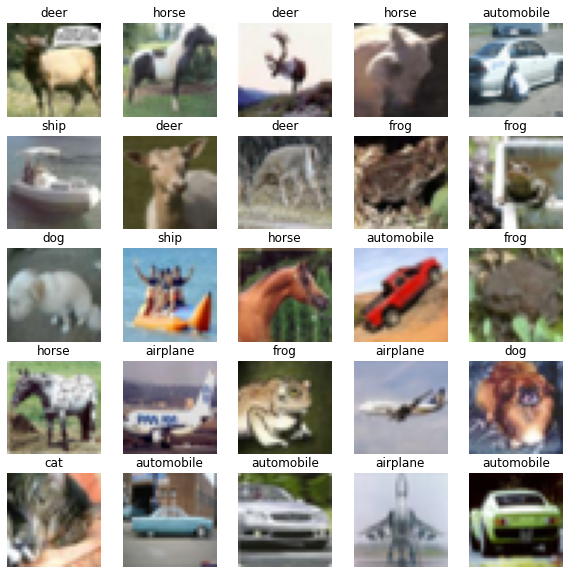

In [14]:
images, labels = next(iter(trainloader))
print(f" {images.shape}, {labels.shape}")

show_batch(images, labels)

# MODEL

In [15]:
def Model():

  inputs = keras.layers.Input(shape = (IMG_SHAPE, IMG_SHAPE, CHAANNELS))

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size = (3, 3), 
                          strides = (1, 1),
                          padding = 'valid',
                          activation = 'relu')(inputs)

  x = keras.layers.Conv2D(filters = 32,
                          kernel_size = (3, 3),
                          strides = (1, 1),
                          padding = 'valid',
                          activation = 'relu')(x)

  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation = 'relu')(x)
  x = keras.layers.Dense(32, activation = 'relu')(x)

  outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return keras.models.Model(inputs = inputs, outputs = outputs)

# CALLBACKS

In [16]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True ## This will ensure the best instance of the model over the validation set.
)

# INITIALIZE MODEL

In [17]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

# COMPILE

In [18]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

# WANDB INIT

In [19]:
wandb.init(entity='pratikraut_', project='ImageClassification')

W&B Run: https://app.wandb.ai/pratikraut_/ImageClassification/runs/1e8ll9kj

# TRAIN

In [20]:
val_images, val_labels = next(iter(testloader))

In [21]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(data_type='image', 
                                   training_data=(val_images, val_labels), 
                                   labels=classes),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8795 - acc: 0.2763 - val_loss: 1.6866 - val_acc: 0.3489
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6656 - acc: 0.3602 - val_loss: 1.6153 - val_acc: 0.3869
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5817 - acc: 0.4045 - val_loss: 1.5322 - val_acc: 0.4270
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5004 - acc: 0.4430 - val_loss: 1.4588 - val_acc: 0.4530
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4375 - acc: 0.4702 - val_loss: 1.3899 - val_acc: 0.4891
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3848 - acc: 0.4923 - val_loss: 1.3428 - val_acc: 0.5110
Epoch 7/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3471 - acc: 0.5081 - val_loss: 1.3348 - val_acc: 0.5200
Epoch 8/100
1563/1563 [==============================] 

In [22]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100, 2))
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

313/313 [==============================] - 1s 3ms/step - loss: 0.9614 - acc: 0.6544
Test Error Rate:  34.56


# INCREASING MODEL CAPACITY

#### NEW MODEL

In [23]:
def ModelIncCapacity():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, CHAANNELS))

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

#### INITIALIZE MODEL

In [24]:
keras.backend.clear_session()
model = ModelIncCapacity()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)               

#### COMPILE

In [25]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

#### WANDB INIT

In [26]:
wandb.init(entity='pratikraut_', project='ImageClassification')

W&B Run: https://app.wandb.ai/pratikraut_/ImageClassification/runs/1dmwhsqm

#### TRAIN

In [27]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(data_type='image', 
                                   training_data=(val_images, val_labels), 
                                   labels=classes),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7778 - acc: 0.3167 - val_loss: 1.5820 - val_acc: 0.3940
Epoch 2/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4668 - acc: 0.4557 - val_loss: 1.3249 - val_acc: 0.5161
Epoch 3/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2919 - acc: 0.5290 - val_loss: 1.2002 - val_acc: 0.5659
Epoch 4/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1788 - acc: 0.5741 - val_loss: 1.1309 - val_acc: 0.5858
Epoch 5/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0830 - acc: 0.6097 - val_loss: 1.1748 - val_acc: 0.5728
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0163 - acc: 0.6366 - val_loss: 1.0128 - val_acc: 0.6420
Epoch 7/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9629 - acc: 0.6575 - val_loss: 1.0218 - val_acc: 0.6381
Epoch 8/100
1563/1563 [==============================] 

#### EVALUATE

In [28]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100, 2))
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

313/313 [==============================] - 1s 3ms/step - loss: 0.7557 - acc: 0.7434
Test Error Rate:  25.66
